In [6]:
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter

# Calling the bunny army
#s1 = Sample("1")
#s2 = Sample("2")
#s3 = Sample("3")
#s4 = Sample("4")
s5 = Sample("5")
#s6 = Sample("6")

#s7 = Sample("7")
#s8 = Sample("8") 
#s9 = Sample("9")
#s10 = Sample("10")

# Dotarem data (HU)
#d1 = Sample("dotarem1")
#d2 = Sample("dotarem2")
#d3 = Sample("dotarem3")
#d4 = Sample("dotarem4")
#d5 = Sample("dotarem5")
#d6 = Sample("dotarem6")

Available directories:
0: 2021_01_20.4511.400.2023_09_30.Rabbit_Aguix_4511_b00000
1: 2021_01_20.4511.500.2023_09_30.Rabbit_Aguix_4511_b00001
2: 2021_01_20.4511.600.2023_09_30.Rabbit_Aguix_4511_b00002
3: 2021_01_20.4511.700.2023_09_30.Rabbit_Aguix_4511_b00003
Conventional file 1 total DICOM files found: 480


KeyboardInterrupt: 

In [10]:
# Look at dicom metadata
import pydicom
file_path = "d://copyRaw//Rabbit_AGUIX_5//2021_01_27.4549.600.2024_03_25.AGUIX_Rabbit_26684_a00003//Conventional//dcm//0294.dcm"

#file_path = "D://copyRaw//Rabbit_AGUIX_dotarem1//2021_01_18.4500.500.2021_01_22.RABJAN00017//Conventional//dcm//0240.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)

#print(.acquisition[1].kedge)

ValueError: embedded null character

1133.0
-1024.0


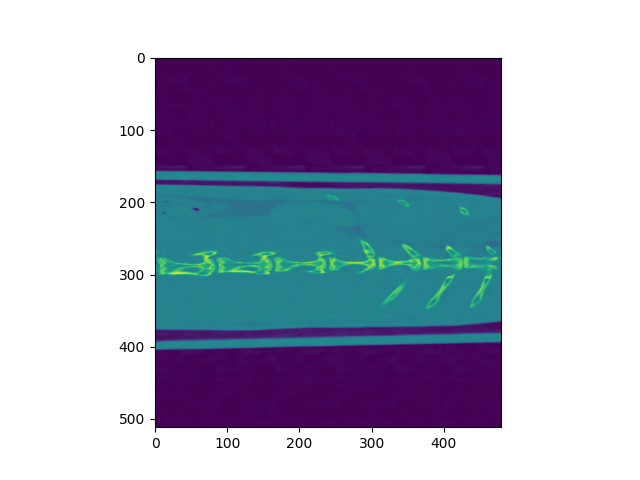

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
#viewS4 = Viewer(s6)
plt.clf()
plt.imshow(d1.acquisition[0].conventional[:,:,455])
print(np.max(d1.acquisition[0].conventional[:,:,455]))
print(np.min(d1.acquisition[0].conventional[:,:,455]))
old_array = d1.acquisition[0].conventional
plt.imshow(old_array[250,:,:])
plt.show()

In [10]:
from skimage import morphology as MM
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter
import pandas as pd
import numpy as np
import nrrd

def makeItEasy(timepoint, slices, sample, mask):
    timepoint = timepoint - 1  # Adjust for zero-based index
    readdata, header = nrrd.read(mask)
    flipped_data = np.swapaxes(readdata, 0, 1)

    #sample.acquisition[timepoint].conventional = sample.acquisition[timepoint].conventional[:, :, 0:slices]
    flipped_data = flipped_data[:, :, 0:slices]

    # Apply dilation to each slice to create the washer_disk
    washer_disk = np.zeros_like(flipped_data, dtype=bool)
    for i in range(flipped_data.shape[2]):
        washer_disk[:, :, i] = MM.dilation(flipped_data[:, :, i], MM.disk(3)) & ~flipped_data[:, :, i]

    indices = np.where(flipped_data == 1)
  
    data = pd.DataFrame(columns=["Signal_HU", "std_HU", "Noise_HU", "std_Noise", "CNR_HU"])
    measurements = []
    
    for i in range(len(sample.acquisition)):

        indices = np.where(flipped_data == 1)
        signal_HU = np.mean(sample.acquisition[i].conventional[indices])
        std_HU = np.std(sample.acquisition[i].conventional[indices])

        indices = np.where(washer_disk == 1)
        noise_HU = np.mean(sample.acquisition[i].conventional[indices])
        std_Noise = np.std(sample.acquisition[i].conventional[indices])

        CNR_HU = (signal_HU - noise_HU) / np.std(sample.acquisition[i].conventional[indices])

        measurements.append([signal_HU, std_HU, noise_HU, std_Noise, CNR_HU])
    
    # Convert measurements list to a DataFrame and append it to data
    new_data = pd.DataFrame(measurements, columns=["Signal_HU", "std_HU", "Noise_HU", "std_Noise", "CNR_HU"])
    data = pd.concat([data, new_data], ignore_index=True)
    print(data)
    data.to_csv("dataframe.csv", index = False)

# Parameters
timepoint = 0
slices = 239
mask = "D:/3d_masks/ivc_s5.seg.nrrd"
sample = Sample("5")  

makeItEasy(timepoint, slices, sample, mask)


Available directories:
0: 2021_01_20.4511.400.2023_09_30.Rabbit_Aguix_4511_b00000
1: 2021_01_20.4511.500.2023_09_30.Rabbit_Aguix_4511_b00001
2: 2021_01_20.4511.600.2023_09_30.Rabbit_Aguix_4511_b00002
3: 2021_01_20.4511.700.2023_09_30.Rabbit_Aguix_4511_b00003
Conventional file 1 total DICOM files found: 480
Spectral/k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral/k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral/k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral/k_gadolinium file 4 total DICOM files found: 480
   Signal_HU     std_HU   Noise_HU  std_Noise    CNR_HU
0  84.294190  17.501778  47.942113  77.863576  0.466869
1  79.999694  16.217510  49.700434  73.423444  0.412665
2  77.169113  16.428377  44.062771  82.767725  0.399991
3  64.848012  15.258140  39.387482  87.233661  0.291866


C:\Users\Chris\AppData\Local\Temp\ipykernel_17664\169575729.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, new_data], ignore_index=True)


(512, 512, 480)


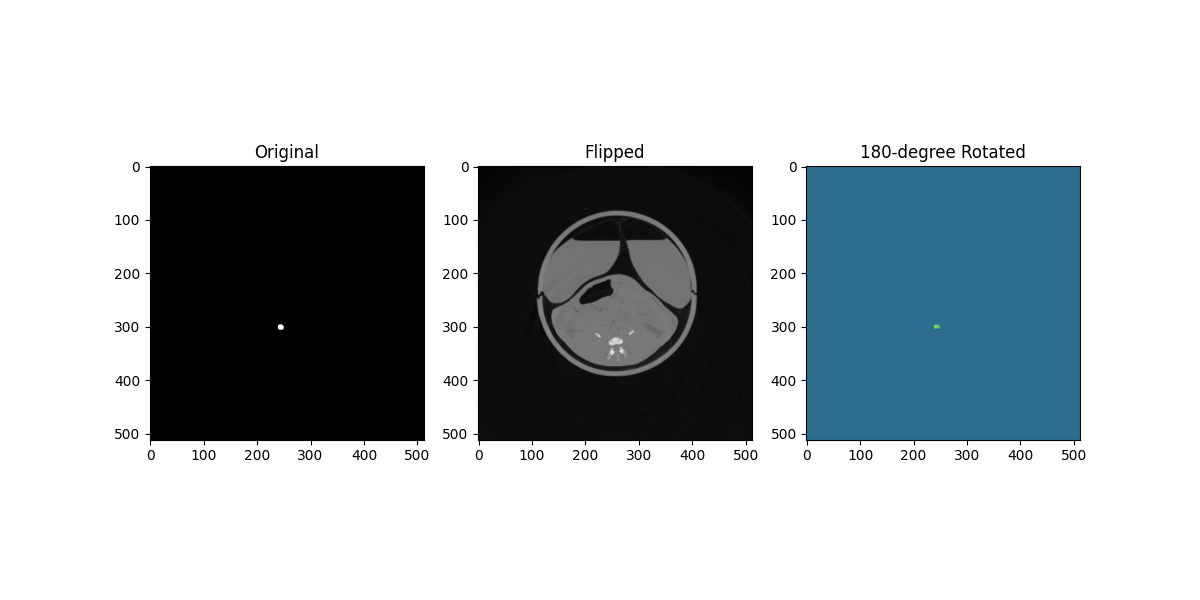

52.026804170547216
47.81510407881384


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd

# Load your data
readdata, header = nrrd.read("D:/3d_masks/ivc_s2_t1.seg.nrrd")
sampview = s2
# Flip both the x and y axes to mimic a 180-degree rotation about the z-axis
flipped_data = np.swapaxes(readdata, 0, 1)
print(flipped_data.shape)

# Plot to compare
plt.figure(figsize=(12, 6))
n = 209
plt.subplot(1, 3, 1)
plt.imshow(flipped_data[:, :, n], cmap='gray')  # Change slice index as necessary
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(sampview.acquisition[2].conventional[:, :, n], cmap='gray')
plt.title("Flipped")

indices = np.where(flipped_data == 1)
#indices = indices[240:]

plt.subplot(1, 3, 3)
plt.imshow(flipped_data[:,:,n]*sampview.acquisition[0].conventional[:, :, n])
plt.title("180-degree Rotated")

plt.show()
    

print(np.mean(sampview.acquisition[3].conventional[indices]))
print(np.std(sampview.acquisition[3].conventional[indices]))


Available directories:
0: 2021_01_20.4511.400.2023_09_30.Rabbit_Aguix_4511_b00000
1: 2021_01_20.4511.500.2023_09_30.Rabbit_Aguix_4511_b00001
2: 2021_01_20.4511.600.2023_09_30.Rabbit_Aguix_4511_b00002
3: 2021_01_20.4511.700.2023_09_30.Rabbit_Aguix_4511_b00003
Conventional file 1 total DICOM files found: 480
Spectral/k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral/k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral/k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral/k_gadolinium file 4 total DICOM files found: 480


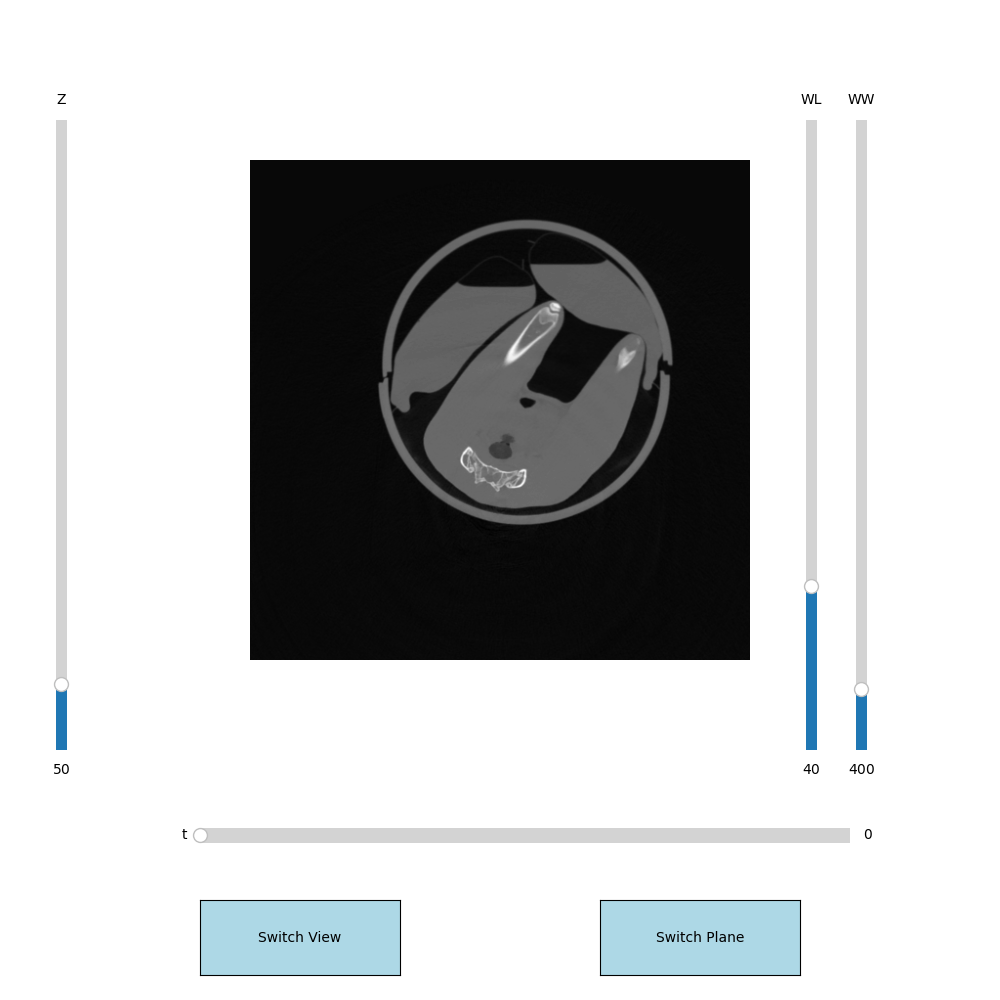

RuntimeError: Another Axes already grabs mouse input

In [7]:
%matplotlib widget
echantillon = Sample("5")
Viewer(echantillon)

In [13]:
#Viewer(s2)
%matplotlib widget
import nrrd
import numpy as np
import scipy.ndimage as ndi
ready3d = Sample("dotarem5") 
readdata, header = nrrd.read("D:/3d_masks/aorta_d4.seg.nrrd")
readdata = np.swapaxes(readdata, 0, 1)
readdata = readdata[:,:,0:480]
#for i in range(2,5):
#    ready3d.acquisition[i].conventional = readdata*ready3d.acquisition[i].conventional
ready3d.acquisition[1].conventional = readdata*ready3d.acquisition[1].conventional
#ready3d.acquisition[1].kedge = readdata*ready3d.acquisition[1].kedge
diameters = 2*np.max(ndi.distance_transform_edt(readdata), axis = (0,1))
indices = np.where(ndi.distance_transform_edt(diameters) > 0.5)
diameters = diameters[indices]
print(diameters.shape)
diameters = diameters[0:197]
print(diameters[0])
print(diameters[197])
print(np.mean(diameters))
print(np.std(diameters))
print(max(diameters))
print(min(diameters))
Viewer(ready3d)

Available directories:
0: 2021_01_19.4506.300.2021_01_22.RABJAN00040
1: 2021_01_19.4506.400.2021_01_22.RABJAN00041
2: 2021_01_19.4506.500.2021_01_22.RABJAN00042
3: 2021_01_19.4506.600.2021_01_22.RABJAN00043
4: 2021_01_19.4506.700.2021_01_22.RABJAN00044
Conventional file 1 total DICOM files found: 480
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem4\2021_01_19.4506.300.2021_01_22.RABJAN00040\Spectral\k_gadolinium.
Conventional file 2 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem4\2021_01_19.4506.400.2021_01_22.RABJAN00041\Spectral\k_gadolinium.
Conventional file 3 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem4\2021_01_19.4506.500.2021_01_22.RABJAN00042\Spectral\k_gadolinium.
Conventional file 4 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem4\2021_01_19.4506.600.2021_01_22.RABJAN00043\Spectral\k_gadolinium.
Conventional file 5 total DICOM files found: 240
No DICOM f

IndexError: index 197 is out of bounds for axis 0 with size 197

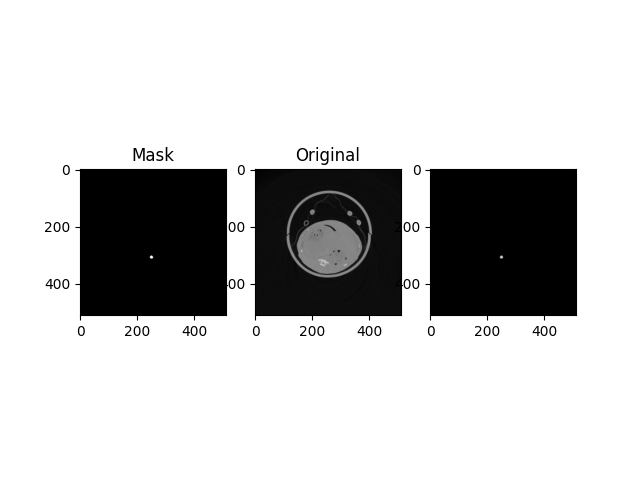

In [3]:
from SPCCT_4D import vesselDiameter
%matplotlib widget
import matplotlib.pyplot as plt
import nrrd
import numpy as np
#s5 = Sample("5")
samp = s1
readdata, header = nrrd.read("D:/3d_masks/aorta_s1.seg.nrrd")
readdata = np.swapaxes(readdata, 0 , 1)
# Clear the current figure (if any) to start fresh
plt.clf()
# Create a subplot for the mask
plt.subplot(1, 3, 1)
plt.imshow(readdata[:, :, 450], cmap='gray')  # Assuming the slice index 250 is correct
plt.title("Mask")

# Create a subplot for the original image
plt.subplot(1, 3, 2)
plt.imshow(s1.acquisition[1].conventional[:, :, 450], cmap='gray')  # Ensure the index is correctly aligned with your data
plt.title("Original")


plt.subplot(1,3,3)
plt.imshow(readdata[:, :, 450]*samp.acquisition[1].conventional[:, :, 450], cmap = 'gray')
# Show the plots
plt.show()
#plt.clf()
#samp.acquisition[1].conventional = readdata*s1.acquisition[1].conventional
#Viewer(samp)
#samp.acquisition[0].conventional[:,:,0:239] = samp.acquisition[0].conventional[:,:,240:479]
#samp.acquisition[0].conventional = samp.acquisition[0].conventional[:,:,0:239]

# Load previously made mask to evaluate quality
#vesselDiameter(samp, "Masks\\IVC_s4_292_t1.npy")
#vesselDiameter(samp, "Vessel_Masks\\SAA_d5_167.npy")
#vesselDiameter(samp, "Kidney_Masks\\r_cortex_d5_41.npy")

#vesselDiameter(samp, "D:/3d_masks/aorta_s1.seg.nrrd")


10.770329614269007


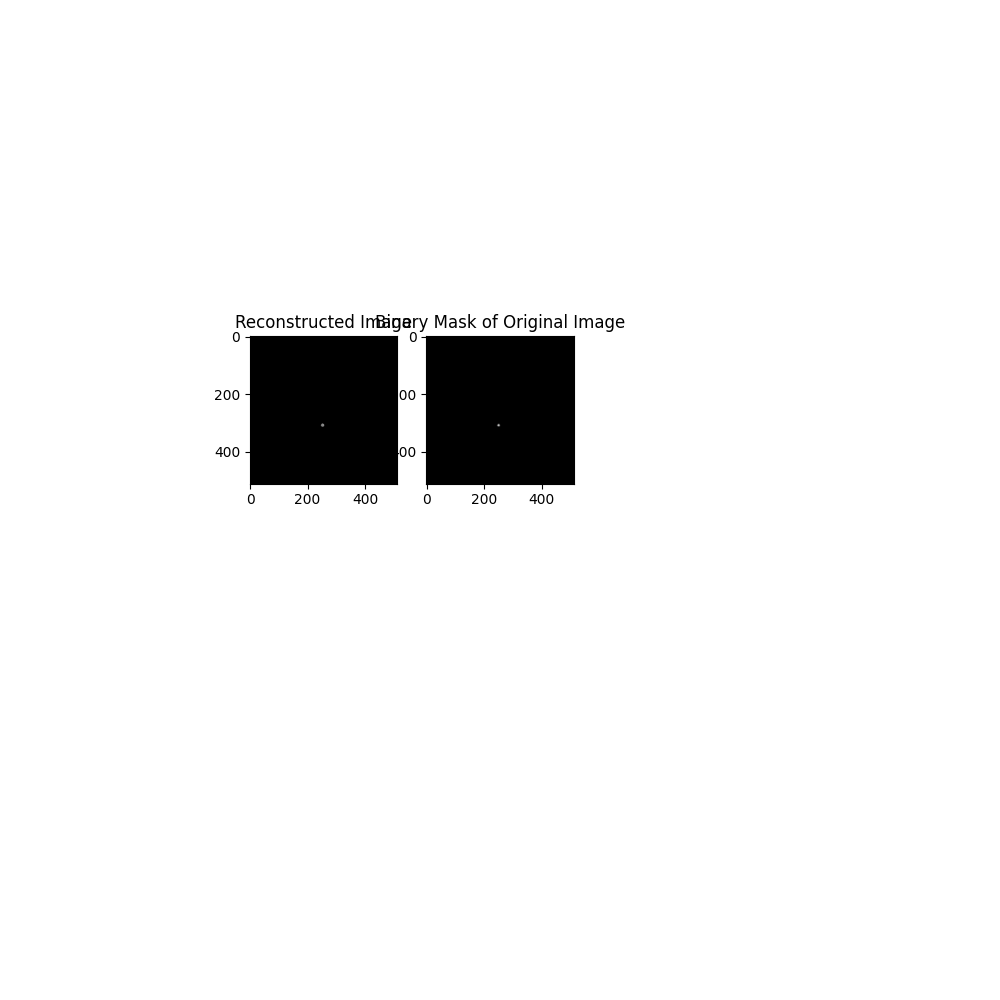

(131, 2)


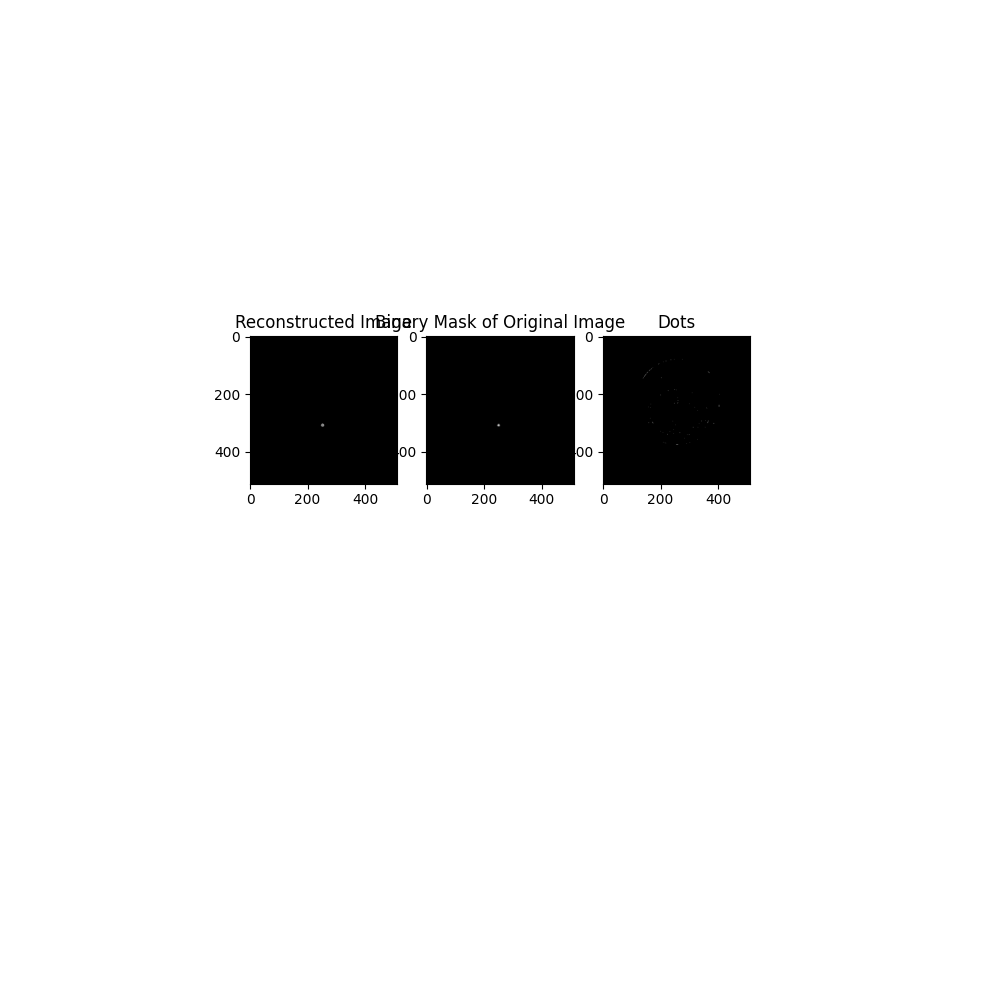

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology as MM
import scipy.ndimage as ndi

start = s1.acquisition[1].conventional[:,:,459]
start_mask = np.load("D:/3d_masks/aorta_s1.seg.nrrd")



#start_mask = np.all(start_mask == [1, 0, 0, 0.5], axis=-1)
#start_mask = start_mask.astype(int)

#stop_mask = np.all(stop_mask == [1, 0, 0, 0.5], axis=-1)
#stop_mask = stop_mask.astype(int)

def greyscale_mask(mask):
    to3D = np.all(mask == [1,0,0,0.5], axis = -1)
    to3D = to3D.astype(int)
    return to3D

def generate_marker_from_coords(shape, coordinates):
    marker = np.zeros(shape)
    marker[coordinates[:, 0], coordinates[:, 1]] = True
    return marker

#edt = ndi.distance_transform_edt(to3D)
    #maxima = MM.h_maxima(edt, 2)
    #coordinates = np.where(maxima == 1)
    #print(coordinates[0])
    #coordinates = np.asarray(coordinates).T
    #print(coordinates[0])
plt.clf()
plt.subplot(1, 3, 1)
plt.imshow(greyscale_mask(start_mask)*start, cmap='gray')
plt.title("Reconstructed Image")

nxt = s1.acquisition[1].conventional[:,:,458]
binary_start = nxt > np.percentile(nxt, 95)
edt = ndi.distance_transform_edt(binary_start)

coords = MM.h_maxima(edt, 2)
coordinates = np.where(coords == 1)
coordinates = np.asarray(coordinates).T

dotplot = generate_marker_from_coords(start.shape, coordinates)

edt = ndi.distance_transform_edt(greyscale_mask(start_mask))
radius = np.max(edt)
print(radius*2)

plt.subplot(1, 3, 2)
plt.imshow(edt, cmap='gray')
plt.title("Binary Mask of Original Image")
plt.show()
print(coordinates.shape)

plt.subplot(1,3,3)
plt.imshow(dotplot, cmap = "gray")
plt.title("Dots")
plt.show()




In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_dilation

class VesselAnalyzer:
    def __init__(self, sample, path=None):
        self.sample = sample
        self.path = path
        self.data = pd.DataFrame(columns=["Signal_HU", "Noise_HU", "CNR_HU", "Signal_Kedge", "Noise_Kedge", "CNR_Kedge"])
        self.masks = []
        self.mask_overlay = None

        self.viewer = Viewer(sample)  # Assuming Viewer is defined elsewhere
        self.cid_click = self.viewer.fig.canvas.mpl_connect('button_press_event', self.on_mouse_click)

    def on_mouse_click(self, event):
        if event.inaxes == self.viewer.ax:
            self.add_circular_roi(event.xdata, event.ydata)
            plt.draw()

    def add_circular_roi(self, x_center, y_center):
        radius = 2.5  # For a diameter of 5 pixels
        washer_radius = 4.5  # For a washer with an outer diameter of 9 pixels (4.5 + 2.5)

        # Create circular ROI and washer mask
        nx, ny = self.viewer.image_display.get_array().shape[1], self.viewer.image_display.get_array().shape[0]
        y, x = np.ogrid[:ny, :nx]
        circular_mask = (x - x_center) ** 2 + (y - y_center) ** 2 <= radius ** 2
        washer_mask = (x - x_center) ** 2 + (y - y_center) ** 2 <= washer_radius ** 2
        washer_mask ^= circular_mask  # Remove the inner circular ROI

        # Process the mask and washer, calculate statistics
        self.process_selection(circular_mask, washer_mask, self.sample)

        # Optionally, create an overlay image to show the ROI
        if self.mask_overlay is not None:
            self.mask_overlay.remove()
        self.mask_overlay = self.viewer.ax.imshow(circular_mask + washer_mask, cmap='coolwarm', alpha=0.5)
        self.viewer.fig.canvas.draw_idle()

    def process_selection(self, circular_mask, washer_mask, sample):
        # Placeholder for image data, replace with actual image data
        measurements = []
        image_data = self.viewer.image_display.get_array()

        # Compute statistics for the circular ROI
        signal_HU = np.mean(image_data[circular_mask])
        noise_HU = np.mean
    
        for i in range(len(sample.acquisition)):
            conventional = sample.acquisition[i].conventional[:, :, self.viewer.slice_slider.val]
        
            # Calculate metrics for conventional and k-edge images
            signal_HU, noise_HU = np.mean(conventional[circular_mask]), np.mean(conventional[washer_mask])
            CNR_HU = (signal_HU - noise_HU) / np.std(conventional[washer_mask])

            kedge = sample.acquisition[i].kedge[:, :, self.viewer.slice_slider.val] if sample.acquisition[i].kedge is not None else None
        
            if kedge is None or (isinstance(kedge, np.ndarray) and np.isnan(kedge).any()):
                signal_Kedge, noise_Kedge, CNR_Kedge = np.nan, np.nan, np.nan
            
            else:
                kedge = sample.acquisition[i].kedge[:, :, self.viewer.slice_slider.val]
                signal_Kedge, noise_Kedge = np.mean(kedge[circular_mask]), np.mean(kedge[washer_mask])
                CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])
        
            # Append metrics to the list
            measurements.append([signal_HU, noise_HU, CNR_HU, signal_Kedge, noise_Kedge, CNR_Kedge])
    
        # Convert measurements list to a DataFrame and append it to self.data
        new_data = pd.DataFrame(measurements, columns=self.data.columns)
        self.data = pd.concat([self.data, new_data], ignore_index=True)
        print(self.data)
        self.data.to_csv("dataframe.csv", index = False)


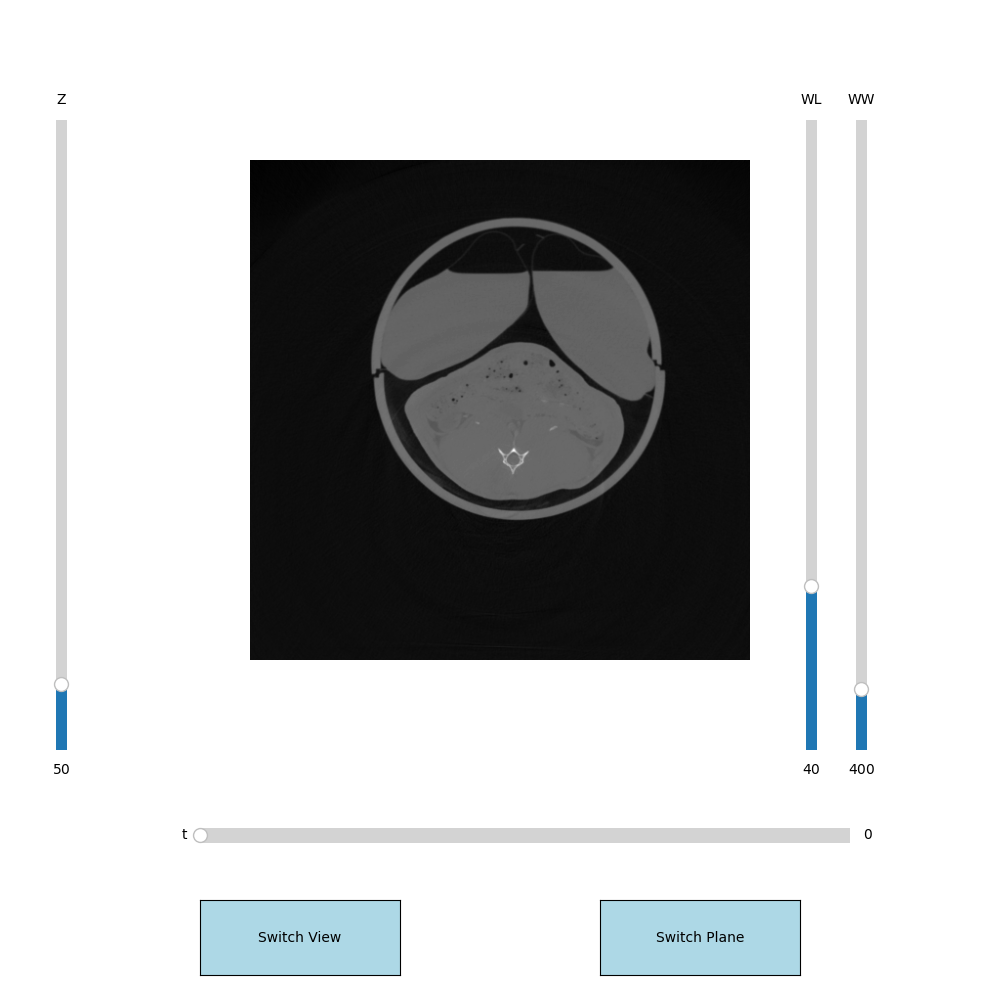

    Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0 -552.142857 -502.863636 -0.436149      0.126667     0.282273  -0.528537
1  114.238095  116.090909 -0.096130      0.547619     0.521818   0.065033
2  115.142857  105.681818  0.534546      0.494286     0.454091   0.158109
3   96.761905   96.159091  0.044077      0.327619     0.318636   0.055798


C:\Users\Chris\AppData\Local\Temp\ipykernel_13548\3856978850.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


PermissionError: [Errno 13] Permission denied: 'dataframe.csv'

    Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0 -552.142857 -502.863636 -0.436149      0.126667     0.282273  -0.528537
1  114.238095  116.090909 -0.096130      0.547619     0.521818   0.065033
2  115.142857  105.681818  0.534546      0.494286     0.454091   0.158109
3   96.761905   96.159091  0.044077      0.327619     0.318636   0.055798
4 -640.947368 -627.023810 -0.220300      0.597895     0.625238  -0.402690
5   55.526316   50.380952  0.330953      0.000000     0.000000        NaN
6   62.473684   58.619048  0.345035      0.000000     0.000000        NaN
7   56.736842   47.000000  0.834781      0.000000     0.005238  -0.451716


C:\Users\Chris\AppData\Local\Temp\ipykernel_13548\3856978850.py:66: RuntimeWarning: invalid value encountered in scalar divide
  CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])


PermissionError: [Errno 13] Permission denied: 'dataframe.csv'

     Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  -552.142857 -502.863636 -0.436149      0.126667     0.282273  -0.528537
1   114.238095  116.090909 -0.096130      0.547619     0.521818   0.065033
2   115.142857  105.681818  0.534546      0.494286     0.454091   0.158109
3    96.761905   96.159091  0.044077      0.327619     0.318636   0.055798
4  -640.947368 -627.023810 -0.220300      0.597895     0.625238  -0.402690
5    55.526316   50.380952  0.330953      0.000000     0.000000        NaN
6    62.473684   58.619048  0.345035      0.000000     0.000000        NaN
7    56.736842   47.000000  0.834781      0.000000     0.005238  -0.451716
8  -983.800000 -893.355556 -0.718422      0.017000     0.079111  -0.675934
9    28.650000   24.377778  0.521972      0.000000     0.000000        NaN
10   21.300000   27.022222 -0.988821      0.000000     0.000000        NaN
11   24.900000   28.044444 -0.461409      0.000000     0.000000        NaN


C:\Users\Chris\AppData\Local\Temp\ipykernel_13548\3856978850.py:66: RuntimeWarning: invalid value encountered in scalar divide
  CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])


PermissionError: [Errno 13] Permission denied: 'dataframe.csv'

C:\Users\Chris\AppData\Local\Temp\ipykernel_13548\3856978850.py:66: RuntimeWarning: invalid value encountered in scalar divide
  CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])


     Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  -552.142857 -502.863636 -0.436149      0.126667     0.282273  -0.528537
1   114.238095  116.090909 -0.096130      0.547619     0.521818   0.065033
2   115.142857  105.681818  0.534546      0.494286     0.454091   0.158109
3    96.761905   96.159091  0.044077      0.327619     0.318636   0.055798
4  -640.947368 -627.023810 -0.220300      0.597895     0.625238  -0.402690
5    55.526316   50.380952  0.330953      0.000000     0.000000        NaN
6    62.473684   58.619048  0.345035      0.000000     0.000000        NaN
7    56.736842   47.000000  0.834781      0.000000     0.005238  -0.451716
8  -983.800000 -893.355556 -0.718422      0.017000     0.079111  -0.675934
9    28.650000   24.377778  0.521972      0.000000     0.000000        NaN
10   21.300000   27.022222 -0.988821      0.000000     0.000000        NaN
11   24.900000   28.044444 -0.461409      0.000000     0.000000        NaN
12 -989.100000 -996.59090

C:\Users\Chris\AppData\Local\Temp\ipykernel_13548\3856978850.py:66: RuntimeWarning: invalid value encountered in scalar divide
  CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])


     Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  -552.142857 -502.863636 -0.436149      0.126667     0.282273  -0.528537
1   114.238095  116.090909 -0.096130      0.547619     0.521818   0.065033
2   115.142857  105.681818  0.534546      0.494286     0.454091   0.158109
3    96.761905   96.159091  0.044077      0.327619     0.318636   0.055798
4  -640.947368 -627.023810 -0.220300      0.597895     0.625238  -0.402690
5    55.526316   50.380952  0.330953      0.000000     0.000000        NaN
6    62.473684   58.619048  0.345035      0.000000     0.000000        NaN
7    56.736842   47.000000  0.834781      0.000000     0.005238  -0.451716
8  -983.800000 -893.355556 -0.718422      0.017000     0.079111  -0.675934
9    28.650000   24.377778  0.521972      0.000000     0.000000        NaN
10   21.300000   27.022222 -0.988821      0.000000     0.000000        NaN
11   24.900000   28.044444 -0.461409      0.000000     0.000000        NaN
12 -989.100000 -996.59090

In [ ]:
%matplotlib widget
VesselAnalyzer(s8)